In [20]:
import sys
sys.path.append('reflutils')
import reflutils as ru
import numpy as np

%matplotlib inline
from pypxr.structure import *
from pypxr.reflectivity import *
import matplotlib.pyplot as plt
import seaborn as sns
from refnx.dataset import ReflectDataset
import pandas as pd
sns.set_style("darkgrid")
from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

# Transfer Matrix Method

Removing the low Q, and brewter angle stuff. 

By inspection there are 4 points in the low angle double reflection regiem, and data less that $10^{-6}$ is non physical as there is a brewster angle present there.  

## Bare Silicon

To start off with, we need a way to determine the thickness of silocon oxide present before deposition of the ZnPc. Thus we start by loading in the bare silicon data and fitting it to a model of just silicon and silicon oxide.

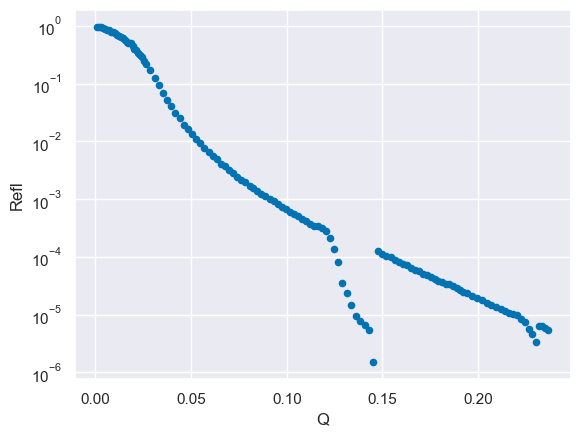

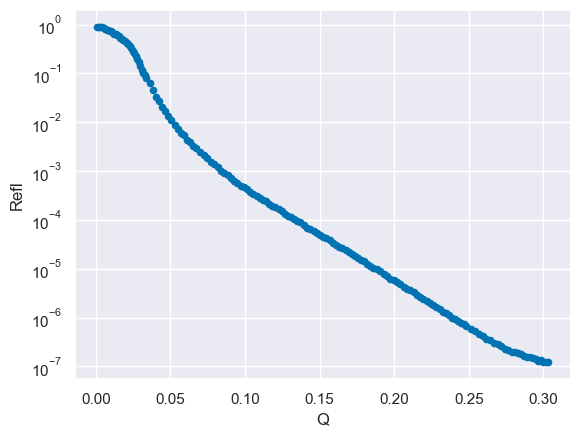

In [2]:
baseSiPath = ru.FileDialog.getDirectory()
bareSi_250 = ru.Refl(baseSiPath / "250.0" / "100.0")
bareSi_320 = ru.Refl(baseSiPath / "320.0" / "100.0")

bareSi_250.plot()
bareSi_320.plot()

Some issues here. The Bare Si data has two domains where the measured reflected beam goes to zero prematurely. This is not physical and tells us that there is something strange happening in this data set. Hopefully, with a mask over these q - values we can get a good fit.

It looks like from .11 - .15 $\AA^{-1}$, and the last 9 points need to be masked out of the data set.

### Masking Bare Si

<Axes: xlabel='Q', ylabel='Refl'>

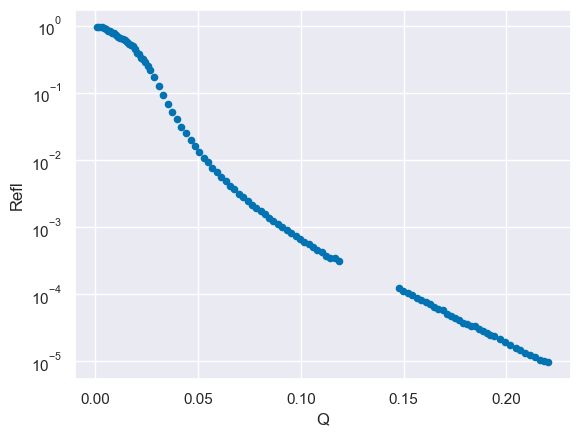

In [3]:
bareSi_250_mask = bareSi_250.refl[:-9]
mask1 = bareSi_250_mask.Q > 0.146
mask2 = bareSi_250_mask.Q < 0.12

bareSi_250_masked = bareSi_250_mask.where(mask1 | mask2).dropna()
bareSi_250_masked.plot(x = "Q", y = "Refl", yerr="Err", kind="scatter", logy=True)

In [4]:
bareSi_250_masked.to_csv("bareSi_250_masked.csv")
bareSi_320.refl.to_csv("bareSi_320.csv")
bareSi_320.images.to_csv("bareSi_320_images.csv")

### Converting to the right format

To start off, we need a function to transform the refl data frames into a form that can be used by the fitting function. This is done by the following function:

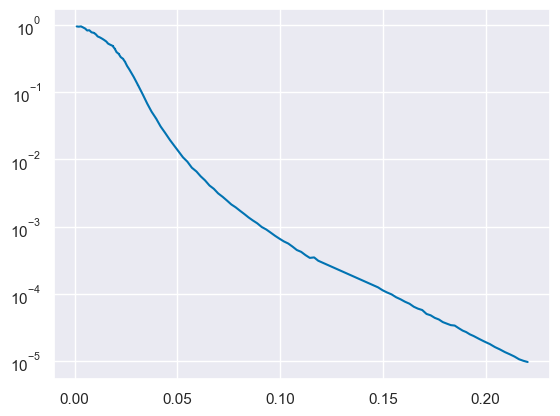

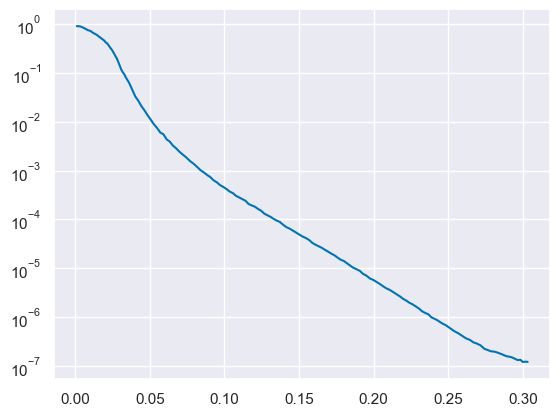

In [5]:
def to_refnx_dataset(refl):
    data = (refl.Q, refl.Refl, refl.Err)
    return ReflectDataset(data)

bareSi_250_masked_dataset = to_refnx_dataset(bareSi_250_masked)
bareSi_320_dataset = to_refnx_dataset(bareSi_320.refl)

bareSi_250_masked_dataset.plot()
plt.yscale("log")
bareSi_320_dataset.plot()
plt.yscale("log")

Now we need to construct the slab mosel using a series of slabs. This is done using the `PXR_MaterialSLD` and the `PXR_SLD`.

- `PXR_MaterialSLD` uses the periodic table package to determine the scattering length density of the material.
- `PXR_SLD` is a class that allows for user constructed materials

### Fitting the data

Here we are looking at the bare sillicon substrait collected at two energies. The first is at 250 eV, an energy well below the carbon k-edge. This provides us with the means to determine the thickness of the silicon oxide layer. In the second, we are looking at 320 eV, an energy in the middle of the carbon k-edge allowing us to probe adventitious carbon on the surface of the sample.

This means that we will be using the first to determine the total thickness of the sample and the second to determine the thickness of any possible carbon layers. Thus the model for such a sample looks something like this 

250 eV : |-Vaccume-|---------------- Sample ----------------|-Silicon-|                 
320 eV : |-Vaccume-|-Adventitious Carbon-|-Silicon Oxide-|-Silicon-|

The model function can then be constructed using known sld's for 250 eV and 320 eV.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

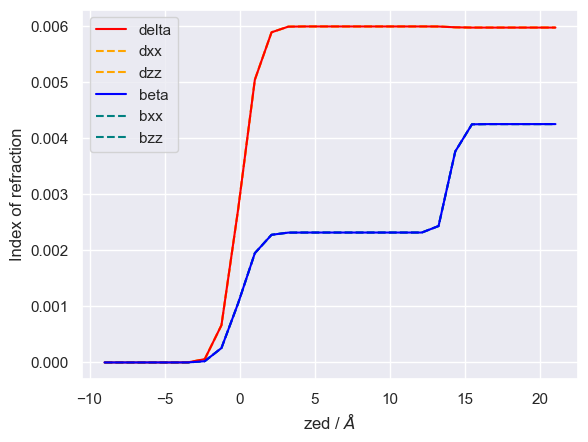

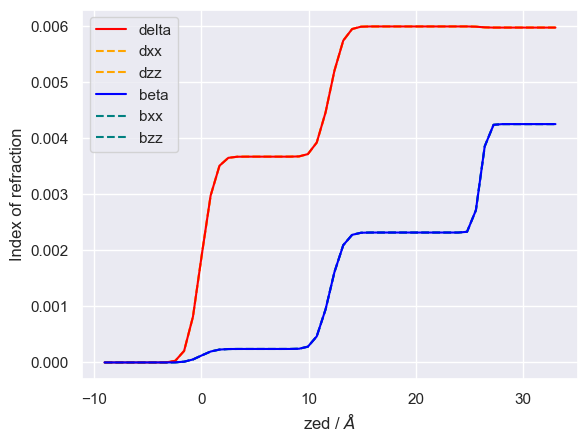

In [35]:
en1 = 250 # eV
en2 = 320 # eV

si = PXR_MaterialSLD("Si", 2.33, name="Si") # substrate
siO2 = PXR_MaterialSLD("SiO2", 2.28, name="SiO2") # surface oxide
carbon = PXR_MaterialSLD("C", 2.2, name="Carbon") # surface carbon
vacuum = PXR_MaterialSLD("", 1, name="Vacuum") # Superstrate


si_slab = si(0, 0.5)
siO2_slab = siO2(14, 1)
carbon_slab = carbon(12, 1)

structure1 = vacuum | siO2_slab | si_slab
structure2 = vacuum | carbon_slab | siO2_slab | si_slab

structure1.plot()
structure2.plot()

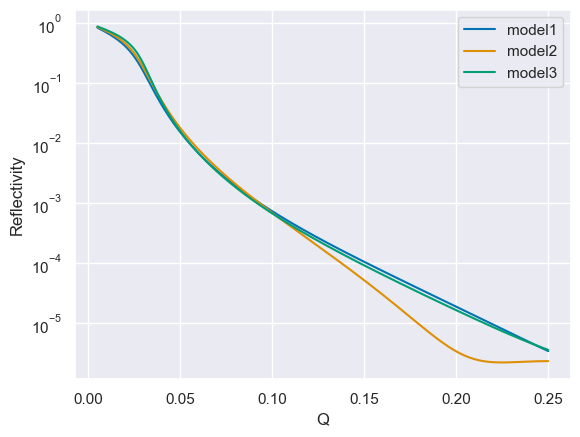

In [56]:
model1 = PXR_ReflectModel(structure1, energy=en1, pol = "s", name="model1")
model2 = PXR_ReflectModel(structure2, energy=en1, pol = "s", name="model2")
model3 = PXR_ReflectModel(structure1, energy=en2, pol = "s", name="model3")

q = np.linspace(0.005, 0.25, 1000)
plt.plot(q, model1(q), label="model1")
plt.plot(q, model2(q), label="model2")
plt.plot(q, model3(q), label="model3")
plt.yscale("log")
plt.ylabel("Reflectivity")
plt.xlabel("Q")
plt.legend()

With these structures in place, we now construct the objective function. This will link the data to the model and allow for the fitting of the data.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

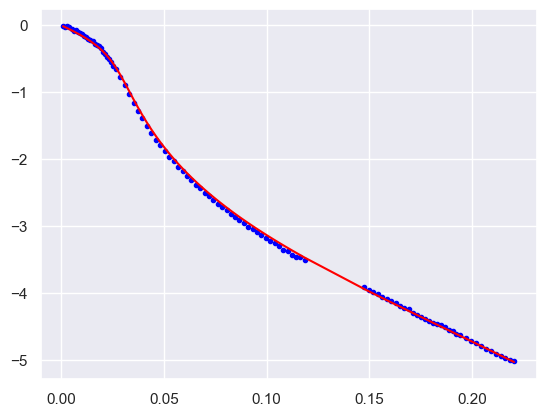

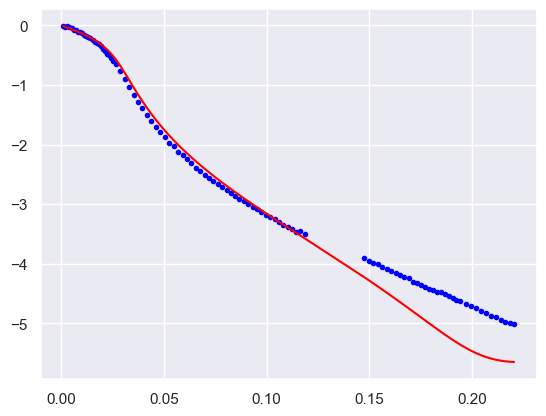

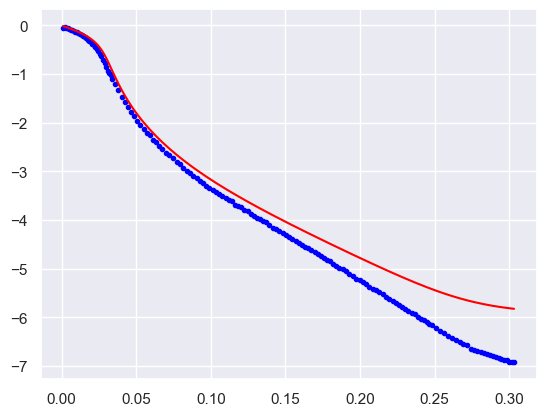

In [58]:
from refnx.analysis import Transform, CurveFitter, Objective

objective1 = Objective(model1, bareSi_250_masked_dataset, transform = Transform("logY"))
objective2 = Objective(model2, bareSi_250_masked_dataset, transform = Transform("logY"))
objective3 = Objective(model3, bareSi_320_dataset, transform = Transform("logY"))

objective1.plot()
objective2.plot()
objective3.plot()

As you can see, the current model is constructed using a compleate guess on thickness and roughness of the various parameters and poorly fits the data. So in the next step, we need to fit the 250 eV dataset and determine the goodness of that fit. 

#### Choosing the right parameters to vary
Now we want to know the exact values for each parameter in the system, but there are some that we allready know, or allready have a very good understanding of. Namely, we know the density of silicon to a very high degree of accuracy, and we know the density of silicon oxide to a very high degree of accuracy. Thus we can fix these parameters to their known values and only fit the thickness of the silicon oxide layer. 

If this does not work out, we can add the silicon dioxide density to our list of varying parameters and fit that as well.

In [39]:
si_slab.thick.setp(vary=False)
si_slab.rough.setp(vary=False, bounds = (0,.01))

siO2_slab.thick.setp(vary=True, bounds=(10, 25))
siO2_slab.rough.setp(vary=True, bounds = (0,5))

# notice that we have not set up the carbon slab yet in the model. The bounds of this slab must be within those of the SiO2 slab

print(objective1.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter: 'SiO2_thick'  , value=14          , bounds=[10.0, 25.0]>
<Parameter: 'SiO2_rough'  , value=1          , bounds=[0.0, 5.0]>


We will start out with a simple scipy L-M fitting technique to see how close we can get these parameters to the truth. Here we do gradient descent on the objective function to find the best fit parameters.

3470039077310846.0: : 4it [00:00, 28.77it/s]    


________________________________________________________________________________
Parameters:      None      
<Parameter: 'SiO2_thick'  , value=13.75 +/- 9.08e-08, bounds=[10.0, 25.0]>
<Parameter: 'SiO2_rough'  , value=3.75 +/- 4.81e-08, bounds=[0.0, 5.0]>
2058847207031879.0


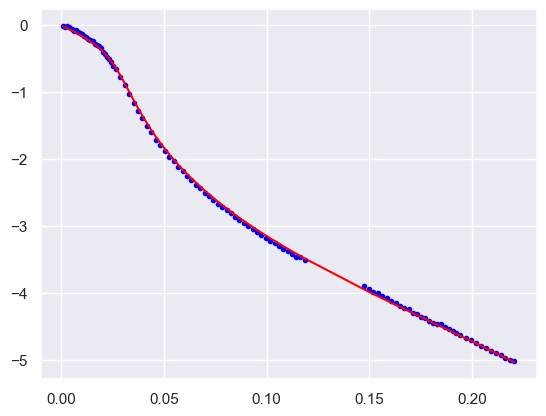

In [44]:
# run this ~ 3 times to get a good starting point. It should converge to arround 13.75 and 3.75
fitter1 = CurveFitter(objective1, nwalkers = 2000)
fitter1.fit("shgo")
objective1.plot()
print(objective1.varying_parameters())
print(objective1.chisqr())

This fit is verry good, with fantastic agreement allong the data set. With this data set, we will now do a Monte Carlo sampling of the parameter space of this function. This will allow us to acurately determine the fit parameters and use quantiles to determine an acurate non symmetric error bar on the thickness and roughness of the sillicon oxide layer. 

To sample these points we will use the estimated covariance matrix from the SHO fit to determine the step size of the random walk. This will allow us to sample the parameter space in a way that is proportional to the likelyhood of the parameters. From this, we will do 200 samples which we will then burn. These samples are discarded because the initial chain is representative of our priors and not of the equilibrated system. We then followup with a production run saving 1 in 100 samples. This is to remove autocorrelation. We save 50 steps, giving a total of 15*200 samples.

In [46]:
fitter1.initialise(pos = "covar", random_state=1)

chain = fitter1.sample(200, random_state=2)
fitter1.reset()
chain = fitter1.sample(50, nthin=10, random_state=3)

100%|██████████| 500/500 [08:39<00:00,  1.04s/it]


________________________________________________________________________________
Parameters:      None      
<Parameter: 'SiO2_thick'  , value=15.5544 +/- 1.64e-07, bounds=[10.0, 25.0]>
<Parameter: 'SiO2_rough'  , value=2.65361 +/- 1.08e-07, bounds=[0.0, 5.0]>


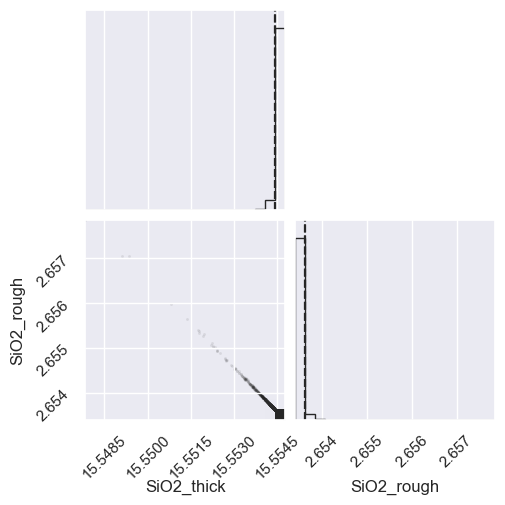

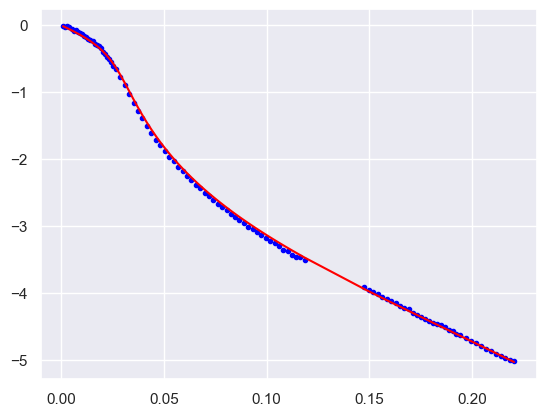

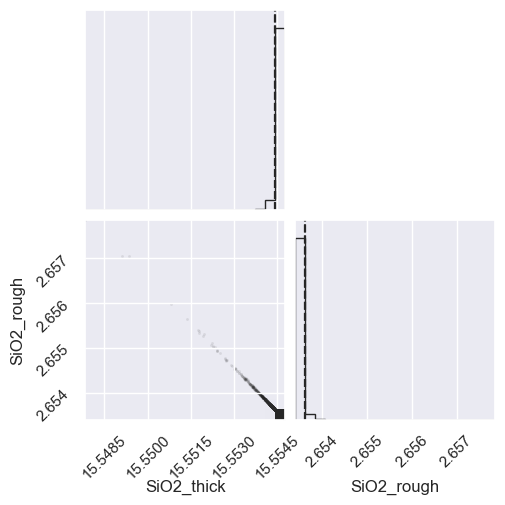

In [47]:
print(objective1.varying_parameters())
objective1.plot()
objective1.corner()

To break down what we see here, there are two parts of these graphs that are important. 

1. Correltation - Notice how the thickness and roughness are highly correlated. This makes prefect sense as the thickness is like the average thickness of the sample, while the roughness is like the standard deviation of this thickness. In other words, the thickness varries over the illuminated surface of the sample, and any features in this shape could be explained by either the thickness or roughness of the sample 

2. The distribution of the samples - Notice how the distribution of the samples is not a normal distribution. This is because the roughness of the sample is constrained to be positive and smaller than the sample thickness, and thus the distribution is skewed. This is important to note as it means that the error bars on the thickness and roughness of the sample are not symmetric.

#### Structure of the sample

We now consider the structure of the sample. To do this, we look at the normalized traces of the dielectric tensor as a function of depth. This results in a plot that looks something like this:

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

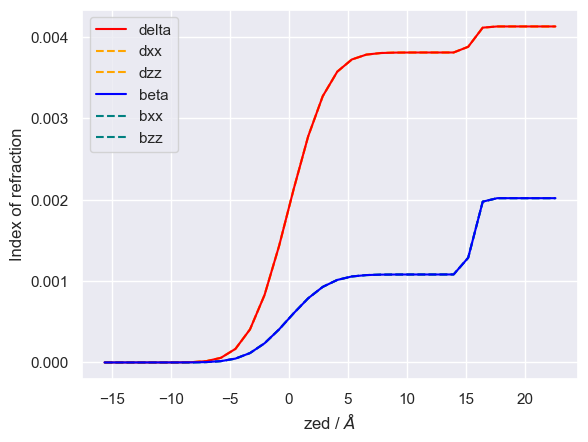

In [59]:
structure1.plot()

Now we want to know if this is all that is needed in the model. This uses the 320 eV data and compare the model regenerated at 320 eV, with proper dielectric constants. 

(<Figure size 640x480 with 1 Axes>, <Axes: >)

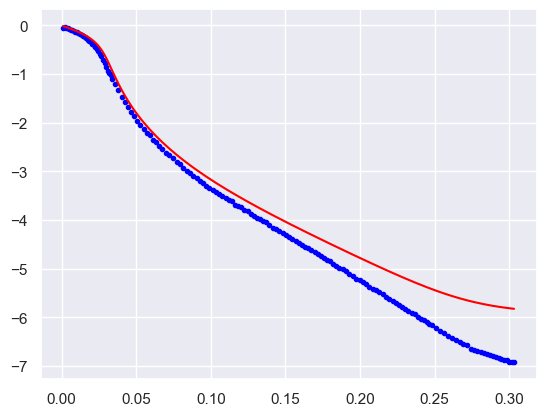

In [60]:
objective3.plot()

C:\Users\hduva\AppData\Local\Temp\ipykernel_6072\2813222880.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refl0.drop([0,1,2,3], inplace=True)
C:\Users\hduva\AppData\Local\Temp\ipykernel_6072\2813222880.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  refl1.drop([0,1,2,3], inplace=True)


<Axes: xlabel='Q', ylabel='Refl'>

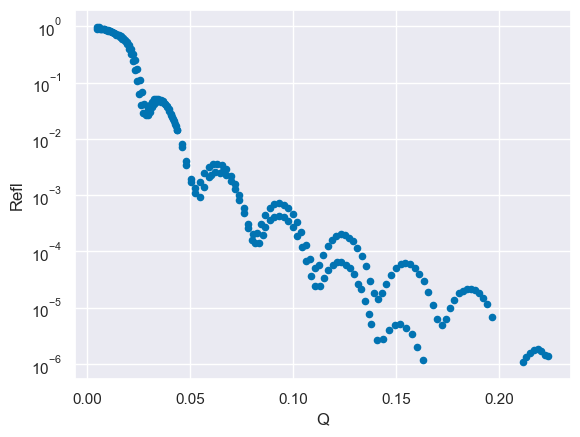

In [29]:
data0 = pd.read_csv("zrt_250.0_100.csv", index_col=0)
data1 = pd.read_csv("zrt_250.0_190.csv", index_col=0)

cols = ["Q", "Refl", "Err"]

refl0 = data0[cols]
refl1 = data1[cols]

refl0.drop([0,1,2,3], inplace=True)
refl1.drop([0,1,2,3], inplace=True)

sliced_refl0 = refl0.where(refl0["Refl"] > 1e-6).dropna()
sliced_refl1 = refl1.where(refl1["Refl"] > 1e-6).dropna()

fig, ax = plt.subplots()
sliced_refl0.plot(x = "Q", y = "Refl", yerr="Err", kind="scatter", logy=True, ax=ax)
sliced_refl1.plot(x = "Q", y = "Refl", yerr="Err", kind="scatter", logy=True, ax= ax)

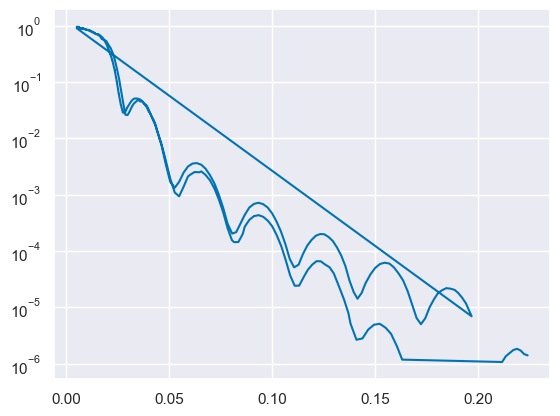

In [18]:
refl = np.concatenate((sliced_refl0, sliced_refl1), axis=0)
q = refl[:,0]
r = refl[:,1]
err = refl[:,2]
refl_tuples = (q, r, err)

data = ReflectDataset(refl_tuples)
data.plot()
plt.yscale('log')

In [20]:
en = 250.0 # [eV]

si = PXR_MaterialSLD("Si", density =2.33, name="Si")
si02 = PXR_MaterialSLD("SiO2",density =  2.28, name="SiO2")
vacuum = PXR_MaterialSLD("", density = 1, name="Vacuum")

n_xx = complex(0.00433633197, 0.000532223552)
n_zz = complex(0.00433633197, 0.000532223552)

znpc = PXR_SLD(n_xx, name="ZnPC")

znpc_s = PXR_SLD(n_xx, name="ZnPC Sub Layer")

In [21]:
import ipywidgets as widgets
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective



@widgets.interact(sio2_thick=(0, 100, 1), sio2_rough = (0,90,1), znpc_thick=(150, 250, 10), znpc_rough=(0,50,1))
def reflStrcut(sio2_thick, sio2_rough, znpc_thick, znpc_rough):
    plt.close("all")
    si_slab = si(0, 0.5)
    si02_slab = si02(sio2_thick, sio2_rough)
    znpc_slab = znpc(znpc_thick, znpc_rough)
    znpc_sub = znpc_s(0,0.5)
    structure = vacuum | znpc_slab | si02_slab | si_slab

    model_spol = PXR_ReflectModel(structure, energy=en, pol='s', name=('spol'))
    model_ppol = PXR_ReflectModel(structure, energy=en, pol='p', name=('ppol'))
    model = PXR_ReflectModel(structure, energy=en, pol = "sp")
    objective = Objective(model, data, transform=Transform('logY'))
    objective.plot()
    plt.show()

interactive(children=(IntSlider(value=25, description='sio2_thick', max=50), IntSlider(value=25, description='…

(<Figure size 640x480 with 1 Axes>, <Axes: >)

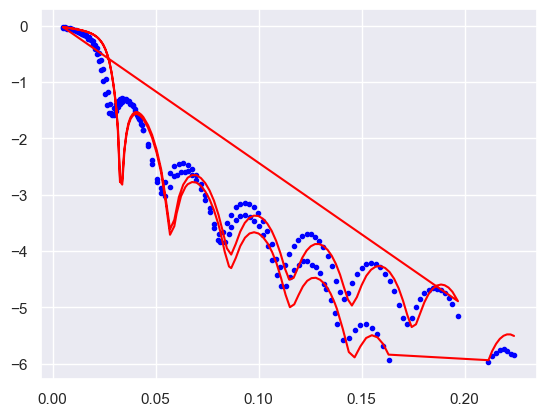

In [7]:
# Slab structure
initial_guess = (8,24,200,3)

si_slab = si(0, 0.5)
si02_slab = si02(8, 24)
znpc_slab = znpc(200, 3)
structure = vacuum | znpc_slab | si02_slab | si_slab

model_spol = PXR_ReflectModel(structure, energy=en, pol='s', name=('spol'))
model_ppol = PXR_ReflectModel(structure, energy=en, pol='p', name=('ppol'))
model = PXR_ReflectModel(structure, energy=en, pol = "sp")
objective = Objective(model, data, transform=Transform('logY'))



objective.plot()

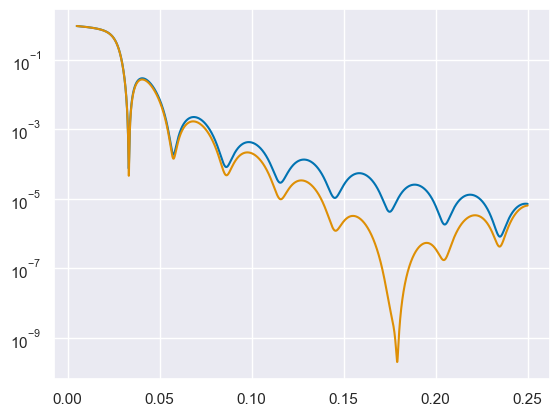

In [9]:
q = np.linspace(0.005, .25, 10000)
plt.plot(q, model_spol(q), label="model")
plt.plot(q, model_ppol(q), label="model")
plt.yscale('log')

In [10]:
si_slab.thick.setp(vary=False)
si_slab.rough.setp(vary=False, bounds = (0,2))

si02_slab.thick.setp(vary=True, bounds=(0,10))
si02_slab.rough.setp(vary=True, bounds = (0,50))
si02_slab.sld.density.setp(vary=False)

znpc_slab.thick.setp(vary=True, bounds=(150,250))
znpc_slab.rough.setp(vary=True, bounds = (0,10))
znpc_slab.sld.delta.setp(vary=False)
znpc_slab.sld.beta.setp(vary=False)


In [11]:
print(objective.varying_parameters())
print(objective.chisqr(), objective.logp(), objective.logl(), objective.logpost())
print(objective.covar())

________________________________________________________________________________
Parameters:      None      
<Parameter: 'ZnPC_thick'  , value=200          , bounds=[150.0, 250.0]>
<Parameter: 'ZnPC_rough'  , value=3          , bounds=[0.0, 10.0]>
<Parameter: 'SiO2_thick'  , value=8          , bounds=[0.0, 10.0]>
<Parameter: 'SiO2_rough'  , value=24          , bounds=[0.0, 50.0]>
3.2450128911404642e+19 -13.122363377404328 -1.6225064455702317e+19 -1.6225064455702317e+19
[[ 2.98618884e-14  1.44238100e-17 -3.00226860e-14  1.48354776e-14]
 [ 1.44238100e-17  2.96236016e-19 -1.43651028e-17  1.66344254e-17]
 [-3.00226860e-14 -1.43651028e-17  3.01851883e-14 -1.49281775e-14]
 [ 1.48354776e-14  1.66344254e-17 -1.49281775e-14  2.61219688e-14]]


In [12]:
fitter = CurveFitter(objective, nwalkers=200)
fitter.initialise('jitter')

100%|██████████| 2000/2000 [05:40<00:00,  5.88it/s]


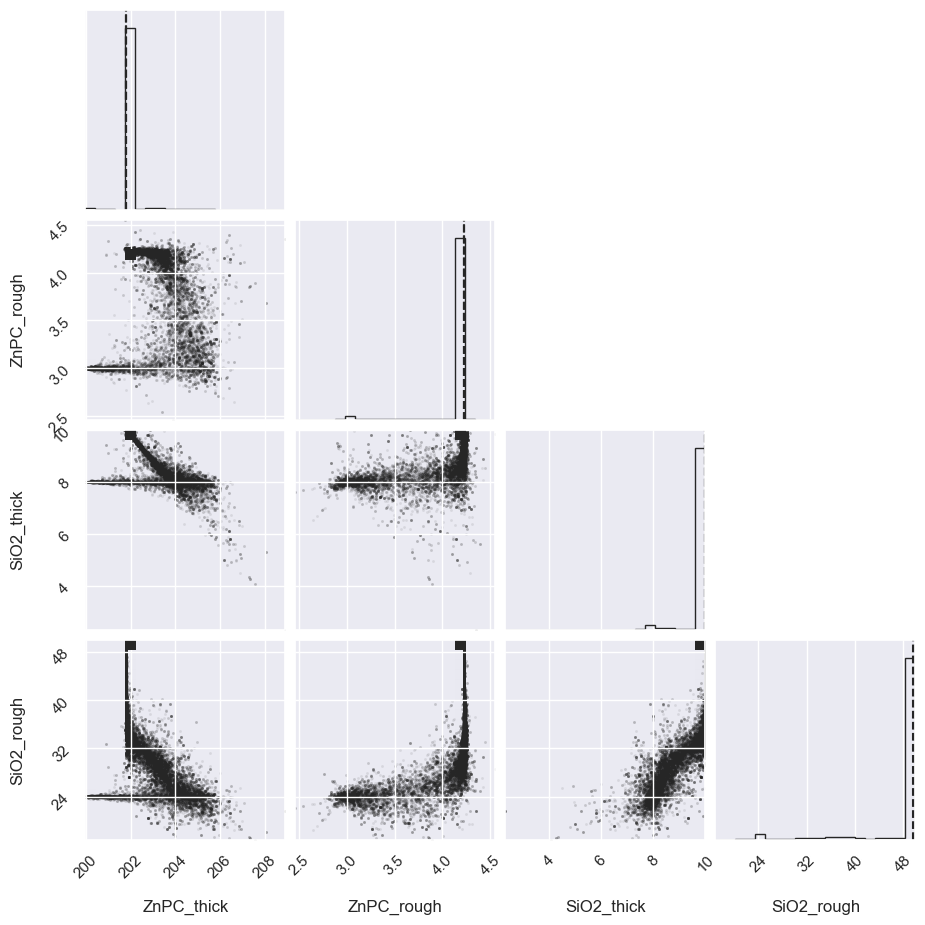

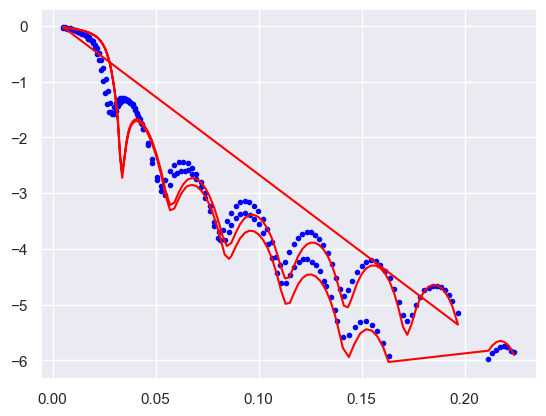

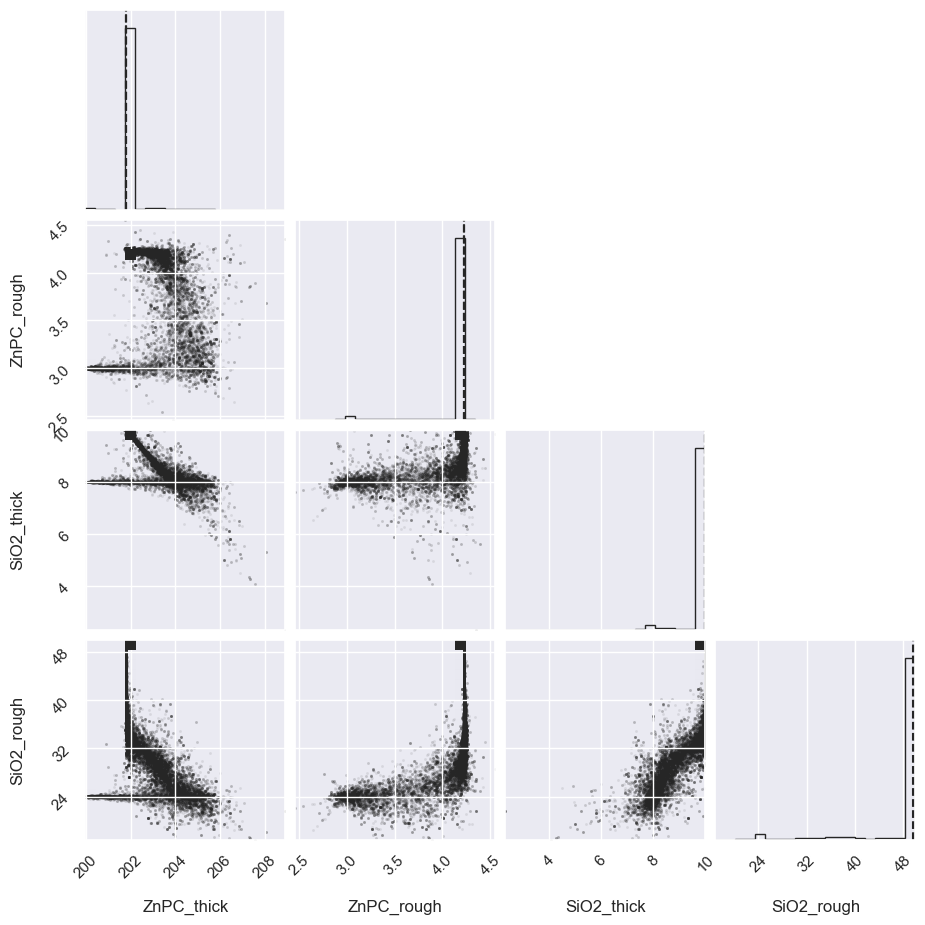

In [13]:
chain = fitter.sample(2000, random_state=1)
objective.plot()
objective.corner()

In [14]:
fitter.reset()
chain = fitter.sample(1000, random_state=1)

100%|██████████| 1000/1000 [02:49<00:00,  5.89it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter: 'ZnPC_thick'  , value=201.798 +/- 3.64e-08, bounds=[150.0, 250.0]>
<Parameter: 'ZnPC_rough'  , value=4.22809 +/- 1.43e-08, bounds=[0.0, 10.0]>
<Parameter: 'SiO2_thick'  , value=10 +/- 4.83e-13, bounds=[0.0, 10.0]>
<Parameter: 'SiO2_rough'  , value=50 +/- 3.75e-08, bounds=[0.0, 50.0]>
1.277813520176575e+19 -13.122363377404328 -6.389067600882873e+18 -6.389067600882873e+18


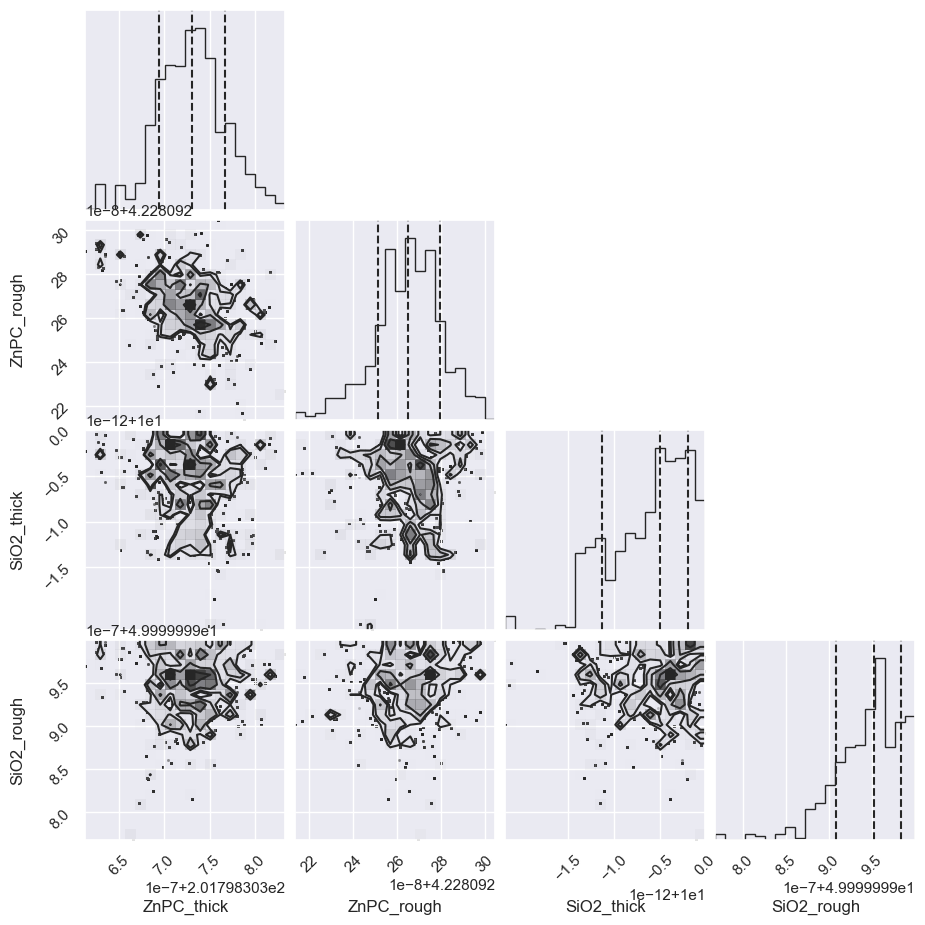

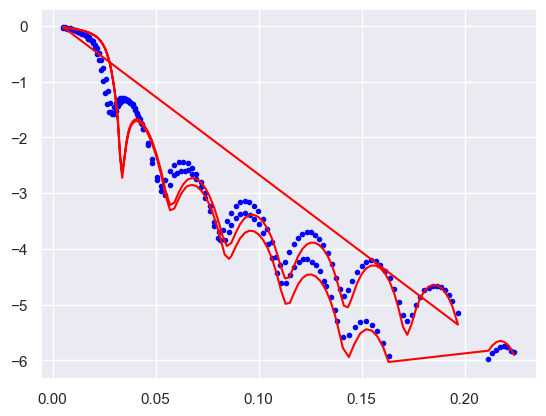

In [15]:
plt.close("all")
objective.corner()
objective.plot()
print(objective.varying_parameters())
print(objective.chisqr(), objective.logp(), objective.logl(), objective.logpost())

(<Figure size 640x480 with 1 Axes>, <Axes: >)

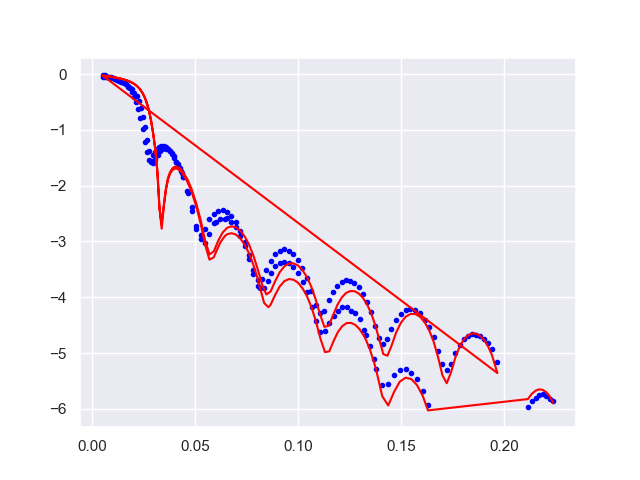